In [1]:
import torch
import torch.optim as optim
import pickle 
import os

import numpy as np
import pandas as pd
from utils.vmf_batch import vMF

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.training_utils import train, evaluate

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def scale(X,scale=(.1,3)):
    a = scale[0]
    b = scale[1]
    s = a + (b-a)*torch.rand(1)
    return X*s

### load iterator

In [4]:
path = './data/%s/iterator/%s/%s%s.pkl'
part = 'soma_centered'
folder = 'Farrow_data'
prefix = 'scaling_'

with open(path%(folder, part, prefix, 'train_iterator'), 'rb') as f:
    train_iterator = pickle.load(f)
    
with open(path%(folder, part, prefix, 'val_iterator'), 'rb') as f:
    val_iterator = pickle.load(f)    

In [5]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

### load model

In [6]:
emb_dim = 32
latent_dim = 32
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [7]:
NUM_CLASSES

14

In [11]:
enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 45.709938049316406


In [12]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL

In [13]:
torch.cuda.empty_cache()

In [14]:

N_EPOCHS= 150
save_path_model= './models/Farrow/scratch/%s/vae_frac%.1f_scaled_best_run%i.pt'
save_path_losses = './models/Farrow/scratch/%s/losses_frac%.1f_scaled_run%i.npy'
save_path_elapsed_time = './models/Farrow/scratch/%s/elapsed_time_frac%.1f_scaled_run%i.npy'

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)


for frac in [0.]:  
    runs = range(1,4)
        
    for run in runs:
        
        
        if os.path.exists(save_path_model%(part,frac,run)):
            state_dict = torch.load(save_path_model%(part,frac,run))
        else:
            state_dict = None
        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
        # load pre-trained model
        if state_dict is not None:
            model.load_state_dict(state_dict['model_state_dict'])
            
            optimizer.load_state_dict(state_dict['optimizer_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            losses = np.load(save_path_losses%(part, frac, run))
            elapsed_time = np.load(save_path_elapsed_time%(part, frac, run))
            
            last_epoch = state_dict['epoch']
            training = list(losses[:last_epoch,:2])
            validation = list(losses[:last_epoch,2:])
            
            best_test_loss = losses[:,2].min()
            
        else:
            model.apply(init_weights)
            classifier.apply(init_weights)
            best_test_loss = np.infty
            
            training = []
            validation=[]
            last_epoch = 0
            elapsed_time = np.zeros((N_EPOCHS,))
            
        
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')

        
        for e in range(last_epoch, N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)
            
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e] = start.elapsed_time(end) # milliseconds

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val

            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, \
                  Time elapsed [s]: {elapsed_time[e]/1000:.2f}')
            
            

            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(part,frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification losss
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(part,frac, run),losses)
                np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)
                
            
            
        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(part,frac, run), losses)
        np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)
        
torch.cuda.empty_cache()

Epoch 0, Train Loss: 1289.86, Test Loss: 5268.83,                   Time elapsed [s]: 30.63
Epoch 1, Train Loss: 1061.45, Test Loss: 4860.99,                   Time elapsed [s]: 30.08
Epoch 2, Train Loss: 828.44, Test Loss: 4949.02,                   Time elapsed [s]: 27.68
Epoch 3, Train Loss: 722.19, Test Loss: 11748.03,                   Time elapsed [s]: 28.83
Epoch 4, Train Loss: 657.73, Test Loss: 5002.20,                   Time elapsed [s]: 28.17
Epoch 5, Train Loss: 608.50, Test Loss: 8761.36,                   Time elapsed [s]: 27.72
Epoch 6, Train Loss: 588.02, Test Loss: 4315.08,                   Time elapsed [s]: 27.81
Epoch 7, Train Loss: 558.37, Test Loss: 8646.86,                   Time elapsed [s]: 29.04
Epoch 8, Train Loss: 531.87, Test Loss: 5249.23,                   Time elapsed [s]: 28.55
Epoch 9, Train Loss: 528.03, Test Loss: 4985.69,                   Time elapsed [s]: 27.86
Epoch 10, Train Loss: 519.47, Test Loss: 4488.93,                   Time elapsed [s]: 2

Epoch 90, Train Loss: 263.02, Test Loss: 1240.63,                   Time elapsed [s]: 27.99
Epoch 91, Train Loss: 280.45, Test Loss: 1475.08,                   Time elapsed [s]: 27.56
Epoch 92, Train Loss: 276.22, Test Loss: 1285.06,                   Time elapsed [s]: 27.63
Epoch 93, Train Loss: 297.65, Test Loss: 1364.56,                   Time elapsed [s]: 27.52
Epoch 94, Train Loss: 284.62, Test Loss: 1204.52,                   Time elapsed [s]: 27.54
Epoch 95, Train Loss: 310.67, Test Loss: 1583.70,                   Time elapsed [s]: 27.52
Epoch 96, Train Loss: 283.63, Test Loss: 1235.13,                   Time elapsed [s]: 27.34
Epoch 97, Train Loss: 265.79, Test Loss: 1267.63,                   Time elapsed [s]: 27.88
Epoch 98, Train Loss: 280.46, Test Loss: 1272.72,                   Time elapsed [s]: 28.30
Epoch 99, Train Loss: 265.32, Test Loss: 1133.58,                   Time elapsed [s]: 28.00
Epoch 100, Train Loss: 258.79, Test Loss: 1075.67,                   Time elapse

Epoch 30, Train Loss: 416.37, Test Loss: 2182.83,                   Time elapsed [s]: 27.27
Epoch 31, Train Loss: 430.28, Test Loss: 3079.47,                   Time elapsed [s]: 27.24
Epoch 32, Train Loss: 435.13, Test Loss: 2912.06,                   Time elapsed [s]: 26.98
Epoch 33, Train Loss: 428.57, Test Loss: 1999.74,                   Time elapsed [s]: 27.10
Epoch 34, Train Loss: 409.95, Test Loss: 1942.98,                   Time elapsed [s]: 27.25
Epoch 35, Train Loss: 397.54, Test Loss: 2175.72,                   Time elapsed [s]: 27.78
Epoch 36, Train Loss: 381.75, Test Loss: 1849.08,                   Time elapsed [s]: 27.65
Epoch 37, Train Loss: 385.92, Test Loss: 1686.44,                   Time elapsed [s]: 27.97
Epoch 38, Train Loss: 383.58, Test Loss: 1757.14,                   Time elapsed [s]: 28.07
Epoch 39, Train Loss: 385.67, Test Loss: 2567.98,                   Time elapsed [s]: 27.07
Epoch 40, Train Loss: 392.90, Test Loss: 2836.08,                   Time elapsed

Epoch 120, Train Loss: 221.67, Test Loss: 856.06,                   Time elapsed [s]: 27.35
Epoch 121, Train Loss: 217.48, Test Loss: 863.32,                   Time elapsed [s]: 27.13
Epoch 122, Train Loss: 216.66, Test Loss: 887.56,                   Time elapsed [s]: 27.18
Epoch 123, Train Loss: 221.92, Test Loss: 849.75,                   Time elapsed [s]: 27.10
Epoch 124, Train Loss: 220.02, Test Loss: 871.14,                   Time elapsed [s]: 27.19
Epoch 125, Train Loss: 217.90, Test Loss: 871.45,                   Time elapsed [s]: 27.61
Epoch 126, Train Loss: 213.34, Test Loss: 885.24,                   Time elapsed [s]: 27.38
Epoch 127, Train Loss: 214.37, Test Loss: 878.56,                   Time elapsed [s]: 27.25
Epoch 128, Train Loss: 219.75, Test Loss: 885.41,                   Time elapsed [s]: 27.20
Epoch 129, Train Loss: 223.17, Test Loss: 891.54,                   Time elapsed [s]: 27.26
Epoch 130, Train Loss: 217.59, Test Loss: 835.55,                   Time elapsed

Epoch 60, Train Loss: 297.61, Test Loss: 1487.89,                   Time elapsed [s]: 27.36
Epoch 61, Train Loss: 312.35, Test Loss: 1404.19,                   Time elapsed [s]: 27.08
Epoch 62, Train Loss: 298.69, Test Loss: 1462.97,                   Time elapsed [s]: 27.17
Epoch 63, Train Loss: 296.33, Test Loss: 1401.80,                   Time elapsed [s]: 27.14
Epoch 64, Train Loss: 298.32, Test Loss: 1350.20,                   Time elapsed [s]: 27.11
Epoch 65, Train Loss: 305.78, Test Loss: 1445.36,                   Time elapsed [s]: 27.48
Epoch 66, Train Loss: 290.48, Test Loss: 1386.63,                   Time elapsed [s]: 27.52
Epoch 67, Train Loss: 282.65, Test Loss: 1489.09,                   Time elapsed [s]: 28.35
Epoch 68, Train Loss: 293.59, Test Loss: 1299.61,                   Time elapsed [s]: 27.83
Epoch 69, Train Loss: 303.89, Test Loss: 1510.65,                   Time elapsed [s]: 27.36
Epoch 70, Train Loss: 293.38, Test Loss: 1610.70,                   Time elapsed

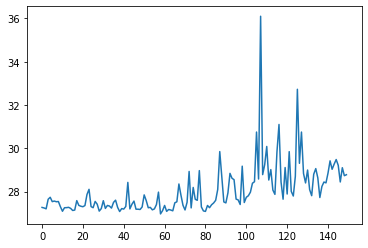

In [16]:
plt.plot(elapsed_time/1000)

In [18]:
print(elapsed_time.mean()/1000)
print(elapsed_time.std()/1000)


28.025633125
1.1423353606102364
